In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Package

In [86]:
# Basic
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
tqdm.pandas()
import pickle

# Load the shp file
import geopandas as gpd
import matplotlib.pyplot as plt

# Load for convert lat/long to geometry
from geopy.geocoders import Nominatim
import urllib
from urllib import parse
from urllib.request import urlopen
from urllib.request import Request
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests
import json
import time

# Data Load

|**Data**|**Content**|**Reason**|
|------|---|---|
|서울시 상권분석서비스(영역-행정동)|행정동 코드, 이름, xy좌표, 자치구, 행정동, 면적|행정동 코드에 대한 전반적인 내용|
|서울시 상권분석서비스(직장인구-행정동)|행정동, 성별/연령대별 직장 인구수|청년 직장을 고려한 입지선정|
|서울시 상권분석서비스(상주인구-행정동)|행정동, 성별/연령대별 상주 인구수|청년들이 상주하고 있는 곳을 고려한 입지 선정|
|서울시 상권분석서비스(추정매출-행정동)|행정동, 업종, 월별/요일별/성별/시간대별 매출 금액|원하는 업종의 매출이 높은 곳을 고려한 입지 선정|
|서울시 상권분석서비스(집객시설-행정동)|행정동, 병원/학교/지하철역/버스정거장 등 시설 수|주거에 필요한 필수 시설을 고려한 입지 선정|
|서울시 상권분석서비스(소득소비-행정동)|행정동, 소득, 품목별 지출 금액|필요한 품목의 지출 비용을 고려한 입지 선정|
|서울시 광진구 안심이 CCTV 연계 현황|광진구 안심이 CCTV 현황|치안을 고려한 입지 선정|
|경찰청_경찰관서 위치 주소 현황|파출소 주소 정보|치안을 고려한 입지 선정|
|서울시 버스정류소 위치정보|서울시 버스정류장 위치 파악|버스정류장 위치를 고려한 입지 선정|
|서울교통공사 지하철역 주소 및 전화번호 정보|서울시 지하철역 위치 파악|지하철역 위치를 고려한 입지 선정|

In [3]:
os.chdir("/content/drive/MyDrive/대학원/3학기/빅데이터/광진구/광진구 빅데이터 공모전/3. 데이터 분석/2. 데이터 분석(Python)/Data")

In [4]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1eRs1n_XE-E1_o-yYw5ZcWcCkzNBvOTdo/광진구 빅데이터 공모전/3. 데이터 분석/2. 데이터 분석(Python)/Data'

In [5]:
path = "./"
os.listdir(path)

['서울시 상권분석서비스(점포-행정동)_2020년.csv',
 '서울시 상권분석서비스(점포-행정동)_2021년.csv',
 '서울시 상권분석서비스(점포-행정동)_2022년.csv',
 '서울시 상권분석서비스(직장인구-상권).csv',
 '서울시 상권분석서비스(직장인구-행정동).csv',
 '서울시 상권분석서비스(상주인구-상권).csv',
 '서울시 상권분석서비스(상주인구-행정동).csv',
 '서울시 상권분석서비스(추정매출-행정동).csv',
 '서울시 상권분석서비스(집객시설-행정동).csv',
 '서울시 상권분석서비스(소득소비-행정동).csv',
 '서울시 광진구 안심이 CCTV 연계 현황.csv',
 '서울시 버스정류소 위치정보.csv',
 '서울교통공사 지하철역 주소 및 전화번호 정보.csv',
 '경찰청_경찰관서 위치 주소 현황_20230811.csv',
 '서울시 자치구별 도보 네트워크 공간정보.csv',
 '서울시 상권분석서비스(점포-행정동)_2023년.csv',
 '서울시 상권분석서비스(영역-행정동)',
 '서울시 상권분석서비스(영역-상권)']

서울시 상권분석서비스(직장인구-행정동).csv

In [6]:
csv_dict = {} # shp 파일을 제외한 모든 csv 파일은 해당 딕녀너리에 저장합니다.

for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_dict[file] = pd.read_csv(path + file, encoding = "cp949")

csv_dict.keys()

dict_keys(['서울시 상권분석서비스(점포-행정동)_2020년.csv', '서울시 상권분석서비스(점포-행정동)_2021년.csv', '서울시 상권분석서비스(점포-행정동)_2022년.csv', '서울시 상권분석서비스(직장인구-상권).csv', '서울시 상권분석서비스(직장인구-행정동).csv', '서울시 상권분석서비스(상주인구-상권).csv', '서울시 상권분석서비스(상주인구-행정동).csv', '서울시 상권분석서비스(추정매출-행정동).csv', '서울시 상권분석서비스(집객시설-행정동).csv', '서울시 상권분석서비스(소득소비-행정동).csv', '서울시 광진구 안심이 CCTV 연계 현황.csv', '서울시 버스정류소 위치정보.csv', '서울교통공사 지하철역 주소 및 전화번호 정보.csv', '경찰청_경찰관서 위치 주소 현황_20230811.csv', '서울시 자치구별 도보 네트워크 공간정보.csv', '서울시 상권분석서비스(점포-행정동)_2023년.csv'])

In [7]:
shp_dict = {}

# Data Pre-Processing

## 서울시 상권분석서비스(영역-상권) **shp file**

* ADSTRD_CD: 행정동 코드
* ADSTRD_NM: 행정동 코드 명
* XCNTS_VALU: x좌표
* YDNTS_VALU: y좌표
* RELM_AR: 영역 면적

In [8]:
path_shp_com = "./서울시 상권분석서비스(영역-상권)/"
os.listdir(path_shp_com)

['서울시 상권분석서비스(영역-상권).prj',
 '서울시 상권분석서비스(영역-상권).cpg',
 '서울시 상권분석서비스(영역-상권).shx',
 '서울시 상권분석서비스(영역-상권).dbf',
 '서울시 상권분석서비스(영역-상권).shp']

In [9]:
seoul_com = gpd.read_file(path_shp_com + "서울시 상권분석서비스(영역-상권).shp")
seoul_com.crs

<Projected CRS: EPSG:5181>
Name: KGD2002 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
gwangjin_com = seoul_com[seoul_com["SIGNGU_CD_"] == "광진구"]
gwangjin_com.drop(columns = ["SIGNGU_CD", "SIGNGU_CD_"], inplace = True)

<ipython-input-10-b36b65e108d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwangjin_com.drop(columns = ["SIGNGU_CD", "SIGNGU_CD_"], inplace = True)


In [11]:
gwangjin_com.head()

,TRDAR_SE_C,TRDAR_SE_1,TRDAR_CD,TRDAR_CD_N,XCNTS_VALU,YDNTS_VALU,ADSTRD_CD,ADSTRD_CD_,RELM_AR,geometry
254,A,골목상권,3110157,자양동우체국,207135.0,447836.0,11215830,자양2동,115158.0,"POLYGON ((207235.236 447999.918, 207257.673 44..."
255,R,전통시장,3130076,능동로골목시장,205916.0,448409.0,11215847,자양4동,28990.0,"POLYGON ((206008.300 448438.490, 206046.748 44..."
256,R,전통시장,3130075,노룬산시장(노룬산골목시장),205724.0,448577.0,11215847,자양4동,10816.0,"POLYGON ((205783.715 448520.549, 205781.148 44..."
257,R,전통시장,3130074,영동교골목시장,205643.0,448742.0,11215847,자양4동,14261.0,"MULTIPOLYGON (((205738.964 448671.652, 205742...."
258,R,전통시장,3130084,신성시장(신성골목시장),207823.0,450945.0,11215770,중곡4동,16181.0,"POLYGON ((207778.408 451014.650, 207804.563 45..."


In [12]:
gwangjin_com = gwangjin_com.astype({"TRDAR_CD": int})
gwangjin_com = gwangjin_com.astype({"ADSTRD_CD": int})

In [13]:
gwangjin_com.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 62 entries, 254 to 315
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TRDAR_SE_C  62 non-null     object  
 1   TRDAR_SE_1  62 non-null     object  
 2   TRDAR_CD    62 non-null     int64   
 3   TRDAR_CD_N  62 non-null     object  
 4   XCNTS_VALU  62 non-null     float64 
 5   YDNTS_VALU  62 non-null     float64 
 6   ADSTRD_CD   62 non-null     int64   
 7   ADSTRD_CD_  62 non-null     object  
 8   RELM_AR     62 non-null     float64 
 9   geometry    62 non-null     geometry
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 5.3+ KB


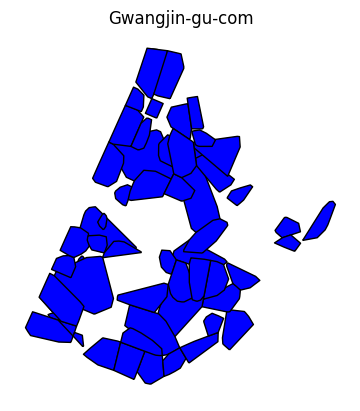

In [14]:
ax = gwangjin_com.convex_hull.plot(color='blue', edgecolor='black')
ax.set_title("Gwangjin-gu-com")
ax.set_axis_off()
plt.show()

## 서울시 상권분석서비스(영역-행정동) **shp file**

In [15]:
path_shp_ad= "./서울시 상권분석서비스(영역-행정동)/"
os.listdir(path_shp_ad)

['서울시 상권분석서비스(영역-행정동).shx',
 '서울시 상권분석서비스(영역-행정동).shp',
 '서울시 상권분석서비스(영역-행정동).cpg',
 '서울시 상권분석서비스(영역-행정동).prj',
 '서울시 상권분석서비스(영역-행정동).dbf']

In [16]:
seoul_ad = gpd.read_file(path_shp_ad + "서울시 상권분석서비스(영역-행정동).shp")
seoul_ad.crs

<Projected CRS: EPSG:5181>
Name: KGD2002 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
seoul_ad.head()

,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,geometry
0,11110515,청운효자동,197342.0,453874.0,2568432.0,"POLYGON ((197482.318 454902.100, 197487.157 45..."
1,11110530,사직동,197383.0,452705.0,1158536.0,"POLYGON ((197702.069 453187.312, 197703.431 45..."
2,11110540,삼청동,198340.0,454312.0,1479255.0,"POLYGON ((197980.839 455346.068, 197995.421 45..."
3,11110550,부암동,196781.0,455266.0,2274739.0,"POLYGON ((196621.023 456395.880, 196628.323 45..."
4,11110560,평창동,197186.0,457344.0,8947328.0,"POLYGON ((197800.719 459064.245, 197782.581 45..."


In [18]:
seoul_ad = seoul_ad.astype({"ADSTRD_CD": int})

In [19]:
seoul_ad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADSTRD_CD   425 non-null    int64   
 1   ADSTRD_NM   425 non-null    object  
 2   XCNTS_VALU  425 non-null    float64 
 3   YDNTS_VALU  425 non-null    float64 
 4   RELM_AR     425 non-null    float64 
 5   geometry    425 non-null    geometry
dtypes: float64(3), geometry(1), int64(1), object(1)
memory usage: 20.0+ KB


In [20]:
gwangjin_ad = seoul_ad[seoul_ad["ADSTRD_CD"].isin(gwangjin_com["ADSTRD_CD"])]

In [21]:
gwangjin_ad.head()

,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,geometry
58,11215840,자양3동,206277.0,447988.0,1196419.0,"POLYGON ((206502.191 448833.470, 206557.876 44..."
59,11215847,자양4동,205623.0,448252.0,1180023.0,"POLYGON ((206164.104 448956.578, 206210.110 44..."
60,11215850,구의1동,207599.0,449114.0,565313.0,"POLYGON ((207972.337 449261.113, 207965.893 44..."
61,11215860,구의2동,208382.0,450180.0,1388041.0,"POLYGON ((209270.675 450767.066, 209269.698 45..."
62,11215870,구의3동,208328.0,448610.0,1027561.0,"POLYGON ((208172.878 449404.420, 208188.854 44..."


In [22]:
gwangjin_ad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 15 entries, 58 to 120
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADSTRD_CD   15 non-null     int64   
 1   ADSTRD_NM   15 non-null     object  
 2   XCNTS_VALU  15 non-null     float64 
 3   YDNTS_VALU  15 non-null     float64 
 4   RELM_AR     15 non-null     float64 
 5   geometry    15 non-null     geometry
dtypes: float64(3), geometry(1), int64(1), object(1)
memory usage: 840.0+ bytes


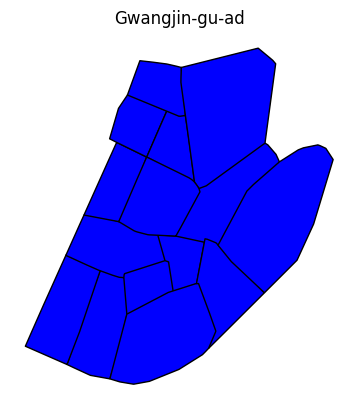

In [23]:
ax = gwangjin_ad.convex_hull.plot(color='blue', edgecolor='black')
ax.set_title("Gwangjin-gu-ad")
ax.set_axis_off()
plt.show()

## 서울시 상권분석서비스(직장인구-행정동).csv

In [24]:
csv_dict["서울시 상권분석서비스(직장인구-행정동).csv"].head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,연령대_10_직장_인구_수,연령대_20_직장_인구_수,연령대_30_직장_인구_수,연령대_40_직장_인구_수,...,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수
0,20191,11110600,가회동,22078,18464,3614,36,2844,8418,5997,...,7075,5310,3712,583,19,1077,1343,687,337,151
1,20191,11110560,평창동,2458,1110,1348,6,340,515,525,...,235,261,239,266,2,235,280,264,344,223
2,20191,11110650,혜화동,5330,2736,2594,20,907,1322,1338,...,591,716,657,421,12,564,731,622,458,207
3,20191,11140650,신당5동,2047,908,1139,6,288,511,484,...,238,228,192,143,3,184,273,256,276,147
4,20191,11170660,이태원2동,2658,1434,1224,15,485,679,481,...,378,257,224,341,5,261,301,224,201,232


In [25]:
csv_dict["서울시 상권분석서비스(직장인구-행정동).csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8061 entries, 0 to 8060
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   기준_년분기_코드            8061 non-null   int64 
 1   행정동_코드               8061 non-null   int64 
 2   행정동_코드_명             8061 non-null   object
 3   총_직장_인구_수            8061 non-null   int64 
 4   남성_직장_인구_수           8061 non-null   int64 
 5   여성_직장_인구_수           8061 non-null   int64 
 6   연령대_10_직장_인구_수       8061 non-null   int64 
 7   연령대_20_직장_인구_수       8061 non-null   int64 
 8   연령대_30_직장_인구_수       8061 non-null   int64 
 9   연령대_40_직장_인구_수       8061 non-null   int64 
 10  연령대_50_직장_인구_수       8061 non-null   int64 
 11  연령대_60_이상_직장_인구_수    8061 non-null   int64 
 12  남성연령대_10_직장_인구_수     8061 non-null   int64 
 13  남성연령대_20_직장_인구_수     8061 non-null   int64 
 14  남성연령대_30_직장_인구_수     8061 non-null   int64 
 15  남성연령대_40_직장_인구_수     8061 non-null   int64 
 16  남성연령대_

In [26]:
work_df = csv_dict["서울시 상권분석서비스(직장인구-행정동).csv"].copy()
work_df = work_df[work_df["행정동_코드"].isin(gwangjin_ad["ADSTRD_CD"].unique())]
work_df = work_df[["기준_년분기_코드", "행정동_코드", "행정동_코드_명", "연령대_20_직장_인구_수", "연령대_30_직장_인구_수"]]
work_df["연령대_2030_직장_인구_수"] = work_df["연령대_20_직장_인구_수"] + work_df["연령대_30_직장_인구_수"]

In [27]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 7 to 8018
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준_년분기_코드         285 non-null    int64 
 1   행정동_코드            285 non-null    int64 
 2   행정동_코드_명          285 non-null    object
 3   연령대_20_직장_인구_수    285 non-null    int64 
 4   연령대_30_직장_인구_수    285 non-null    int64 
 5   연령대_2030_직장_인구_수  285 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 15.6+ KB


In [28]:
work_df.head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,연령대_20_직장_인구_수,연령대_30_직장_인구_수,연령대_2030_직장_인구_수
7,20191,11215820,자양1동,1055,1592,2647
55,20191,11215850,구의1동,546,1134,1680
115,20191,11215847,자양4동,520,654,1174
116,20191,11215770,중곡4동,289,494,783
117,20191,11215710,화양동,1987,2320,4307


## 서울시 상권분석서비스(상주인구-행정동).csv

In [29]:
csv_dict["서울시 상권분석서비스(상주인구-행정동).csv"].head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,연령대_10_상주인구_수,연령대_20_상주인구_수,연령대_30_상주인구_수,연령대_40_상주인구_수,...,남성연령대_60_이상_상주인구_수,여성연령대_10_상주인구_수,여성연령대_20_상주인구_수,여성연령대_30_상주인구_수,여성연령대_40_상주인구_수,여성연령대_50_상주인구_수,여성연령대_60_이상_상주인구_수,총_가구_수,아파트_가구_수,비_아파트_가구_수
0,20191,11110515,청운효자동,13047,6111,6936,2248,1648,1879,2304,...,1235,1052,821,1020,1283,1062,1698,5384,314,5070
1,20191,11110530,사직동,9224,4169,5055,1387,1095,1383,1558,...,1021,697,603,781,856,810,1308,4352,163,4189
2,20191,11110540,삼청동,2831,1344,1487,340,336,422,399,...,383,156,171,220,201,253,486,1413,0,1413
3,20191,11110550,부암동,10055,4850,5205,1490,1394,1277,1647,...,1137,689,633,672,905,909,1397,4243,74,4169
4,20191,11110560,평창동,18615,8775,9840,3018,2691,2303,2848,...,1976,1472,1272,1231,1592,1757,2516,7463,459,7004


In [30]:
csv_dict["서울시 상권분석서비스(상주인구-행정동).csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8054 entries, 0 to 8053
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   기준_년분기_코드           8054 non-null   int64 
 1   행정동_코드              8054 non-null   int64 
 2   행정동_코드_명            8054 non-null   object
 3   총_상주인구_수            8054 non-null   int64 
 4   남성_상주인구_수           8054 non-null   int64 
 5   여성_상주인구_수           8054 non-null   int64 
 6   연령대_10_상주인구_수       8054 non-null   int64 
 7   연령대_20_상주인구_수       8054 non-null   int64 
 8   연령대_30_상주인구_수       8054 non-null   int64 
 9   연령대_40_상주인구_수       8054 non-null   int64 
 10  연령대_50_상주인구_수       8054 non-null   int64 
 11  연령대_60_이상_상주인구_수    8054 non-null   int64 
 12  남성연령대_10_상주인구_수     8054 non-null   int64 
 13  남성연령대_20_상주인구_수     8054 non-null   int64 
 14  남성연령대_30_상주인구_수     8054 non-null   int64 
 15  남성연령대_40_상주인구_수     8054 non-null   int64 
 16  남성연령대_50_상주인구_수     8054

In [31]:
live_df = csv_dict["서울시 상권분석서비스(상주인구-행정동).csv"].copy()
live_df = live_df[live_df["행정동_코드"].isin(gwangjin_ad["ADSTRD_CD"].unique())]
live_df = live_df[["기준_년분기_코드","행정동_코드","행정동_코드_명","연령대_20_상주인구_수","연령대_30_상주인구_수"]]
live_df["연령대_2030_상주인구_수"] = live_df["연령대_20_상주인구_수"] + live_df["연령대_30_상주인구_수"]

In [32]:
live_df.head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,연령대_20_상주인구_수,연령대_30_상주인구_수,연령대_2030_상주인구_수
65,20191,11215710,화양동,8040,4490,12530
66,20191,11215730,군자동,3996,3802,7798
67,20191,11215740,중곡1동,2491,3207,5698
68,20191,11215750,중곡2동,3665,4167,7832
69,20191,11215760,중곡3동,2695,3058,5753


In [33]:
live_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 65 to 7708
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년분기_코드        285 non-null    int64 
 1   행정동_코드           285 non-null    int64 
 2   행정동_코드_명         285 non-null    object
 3   연령대_20_상주인구_수    285 non-null    int64 
 4   연령대_30_상주인구_수    285 non-null    int64 
 5   연령대_2030_상주인구_수  285 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 15.6+ KB


## 서울시 상권분석서비스(추정매출-행정동).csv

In [34]:
csv_dict["서울시 상권분석서비스(추정매출-행정동).csv"].head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,주말_매출_금액,월요일_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20231,11110515,청운효자동,CS100001,한식음식점,4044405878,128881,2933978151,1110427727,515654088,...,38021,4814,57702,59544,618,22428,28949,22890,24205,18154
1,20231,11110515,청운효자동,CS100003,일식음식점,440409096,17294,303271351,137137745,26966279,...,4766,233,6519,9708,266,6051,4598,2503,2118,689
2,20231,11110515,청운효자동,CS100004,양식음식점,2079840033,36469,1261311797,818528236,160368115,...,13732,3049,11639,22519,208,12284,11402,4560,4137,1567
3,20231,11110515,청운효자동,CS100005,제과점,833615483,61657,498790912,334824571,89378438,...,16121,381,19895,40766,341,13420,17153,12246,11275,6222
4,20231,11110515,청운효자동,CS100006,패스트푸드점,31372426,2752,23495453,7876973,6264218,...,300,0,1083,1497,100,656,684,727,313,100


In [35]:
csv_dict["서울시 상권분석서비스(추정매출-행정동).csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50754 entries, 0 to 50753
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   기준_년분기_코드        50754 non-null  int64 
 1   행정동_코드           50754 non-null  int64 
 2   행정동_코드_명         50754 non-null  object
 3   서비스_업종_코드        50754 non-null  object
 4   서비스_업종_코드_명      50754 non-null  object
 5   당월_매출_금액         50754 non-null  int64 
 6   당월_매출_건수         50754 non-null  int64 
 7   주중_매출_금액         50754 non-null  int64 
 8   주말_매출_금액         50754 non-null  int64 
 9   월요일_매출_금액        50754 non-null  int64 
 10  화요일_매출_금액        50754 non-null  int64 
 11  수요일_매출_금액        50754 non-null  int64 
 12  목요일_매출_금액        50754 non-null  int64 
 13  금요일_매출_금액        50754 non-null  int64 
 14  토요일_매출_금액        50754 non-null  int64 
 15  일요일_매출_금액        50754 non-null  int64 
 16  시간대_00~06_매출_금액  50754 non-null  int64 
 17  시간대_06~11_매출_금액  50754 non-null

In [36]:
sales_df = csv_dict["서울시 상권분석서비스(추정매출-행정동).csv"].copy()
sales_df = sales_df[sales_df["행정동_코드"].isin(gwangjin_ad["ADSTRD_CD"].unique())]
condition = sales_df.columns.str.contains("기준_년분기_코드|행정동_코드|행정동_코드_명|서비스_업종_코드|서비스_업종_코드_명|20|30")
sales_df = sales_df.loc[:, condition]
sales_df["연령대_2030_매출_금액"] = sales_df["연령대_20_매출_금액"] + sales_df["연령대_30_매출_금액"]
sales_df["연령대_2030_매출_건수"] = sales_df["연령대_20_매출_건수"] + sales_df["연령대_30_매출_건수"]

In [37]:
sales_df.head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,서비스_업종_코드,서비스_업종_코드_명,연령대_20_매출_금액,연령대_30_매출_금액,연령대_20_매출_건수,연령대_30_매출_건수,연령대_2030_매출_금액,연령대_2030_매출_건수
2203,20231,11215710,화양동,CS100001,한식음식점,10856393568,6239557499,301039,164148,17095951067,465187
2204,20231,11215710,화양동,CS100002,중식음식점,223902821,120708259,7218,4021,344611080,11239
2205,20231,11215710,화양동,CS100003,일식음식점,697206311,350118765,30547,12669,1047325076,43216
2206,20231,11215710,화양동,CS100004,양식음식점,1181843259,563498998,42865,19003,1745342257,61868
2207,20231,11215710,화양동,CS100005,제과점,605620648,407704270,80022,50846,1013324918,130868


In [38]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 2203 to 36814
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   기준_년분기_코드       2038 non-null   int64 
 1   행정동_코드          2038 non-null   int64 
 2   행정동_코드_명        2038 non-null   object
 3   서비스_업종_코드       2038 non-null   object
 4   서비스_업종_코드_명     2038 non-null   object
 5   연령대_20_매출_금액    2038 non-null   int64 
 6   연령대_30_매출_금액    2038 non-null   int64 
 7   연령대_20_매출_건수    2038 non-null   int64 
 8   연령대_30_매출_건수    2038 non-null   int64 
 9   연령대_2030_매출_금액  2038 non-null   int64 
 10  연령대_2030_매출_건수  2038 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 191.1+ KB


## 서울시 상권분석서비스(집객시설-행정동).csv

In [39]:
csv_dict["서울시 상권분석서비스(집객시설-행정동).csv"].head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,집객시설_수,관공서_수,은행_수,종합병원_수,일반_병원_수,약국_수,유치원_수,...,대학교_수,백화점_수,슈퍼마켓_수,극장_수,숙박_시설_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수
0,20233,11290650,정릉4동,133,7.0,3.0,NaN,NaN,12.0,2.0,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,40.0
1,20233,11110515,청운효자동,93,6.0,3.0,NaN,NaN,4.0,1.0,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0
2,20231,11200720,송정동,44,2.0,NaN,NaN,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0
3,20231,11260550,면목5동,42,2.0,1.0,NaN,NaN,3.0,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0
4,20233,11110530,사직동,206,18.0,24.0,NaN,NaN,15.0,NaN,...,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,34.0


In [40]:
csv_dict["서울시 상권분석서비스(집객시설-행정동).csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   기준_년분기_코드  5100 non-null   int64  
 1   행정동_코드     5100 non-null   int64  
 2   행정동_코드_명   5100 non-null   object 
 3   집객시설_수     5100 non-null   int64  
 4   관공서_수      5076 non-null   float64
 5   은행_수       4416 non-null   float64
 6   종합병원_수     624 non-null    float64
 7   일반_병원_수    1644 non-null   float64
 8   약국_수       5076 non-null   float64
 9   유치원_수      3408 non-null   float64
 10  초등학교_수     4332 non-null   float64
 11  중학교_수      3036 non-null   float64
 12  고등학교_수     2484 non-null   float64
 13  대학교_수      1452 non-null   float64
 14  백화점_수      108 non-null    float64
 15  슈퍼마켓_수     1080 non-null   float64
 16  극장_수       900 non-null    float64
 17  숙박_시설_수    1212 non-null   float64
 18  공항_수       24 non-null     float64
 19  철도_역_수     0 non-null      float64
 20  버스_터미널_수

In [41]:
facil_df = csv_dict["서울시 상권분석서비스(집객시설-행정동).csv"].copy()
facil_df = facil_df[facil_df["행정동_코드"].isin(gwangjin_ad["ADSTRD_CD"].unique())]
condition = facil_df.columns.str.contains("기준_년분기_코드|행정동_코드|행정동_코드_명|병원|약국|백화점|슈퍼마켓|공항|철도|버스|지하철")
facil_df = facil_df.loc[:, condition]
facil_df["의료시설_수"] = facil_df["종합병원_수"] + facil_df["일반_병원_수"] + facil_df["약국_수"]
facil_df["생활시설_수"] = facil_df["백화점_수"] + facil_df["슈퍼마켓_수"]
facil_df["교통시설_수"] = facil_df["공항_수"] + facil_df["철도_역_수"] + facil_df["버스_터미널_수"] + facil_df["지하철_역_수"] + facil_df["버스_정거장_수"]

In [42]:
facil_df.head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,종합병원_수,일반_병원_수,약국_수,백화점_수,슈퍼마켓_수,공항_수,철도_역_수,버스_터미널_수,지하철_역_수,버스_정거장_수,의료시설_수,생활시설_수,교통시설_수
170,20231,11215840,자양3동,NaN,NaN,8.0,1.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
171,20232,11215840,자양3동,NaN,NaN,8.0,1.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
172,20233,11215840,자양3동,NaN,NaN,8.0,1.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
173,20231,11215847,자양4동,NaN,1.0,15.0,NaN,1.0,NaN,NaN,NaN,1.0,16.0,NaN,NaN,NaN
174,20232,11215847,자양4동,NaN,1.0,15.0,NaN,1.0,NaN,NaN,NaN,1.0,16.0,NaN,NaN,NaN


In [43]:
facil_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180 entries, 170 to 5084
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   기준_년분기_코드  180 non-null    int64  
 1   행정동_코드     180 non-null    int64  
 2   행정동_코드_명   180 non-null    object 
 3   종합병원_수     24 non-null     float64
 4   일반_병원_수    60 non-null     float64
 5   약국_수       180 non-null    float64
 6   백화점_수      12 non-null     float64
 7   슈퍼마켓_수     60 non-null     float64
 8   공항_수       0 non-null      float64
 9   철도_역_수     0 non-null      float64
 10  버스_터미널_수   12 non-null     float64
 11  지하철_역_수    108 non-null    float64
 12  버스_정거장_수   180 non-null    float64
 13  의료시설_수     0 non-null      float64
 14  생활시설_수     0 non-null      float64
 15  교통시설_수     0 non-null      float64
dtypes: float64(13), int64(2), object(1)
memory usage: 23.9+ KB


## 서울시 상권분석서비스(소득소비-행정동).csv

In [44]:
csv_dict["서울시 상권분석서비스(소득소비-행정동).csv"].head()

,기준_년분기_코드,행정동_코드,행정동_코드_명,월_평균_소득_금액,소득_구간_코드,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,생활용품_지출_총금액,의료비_지출_총금액,교통_지출_총금액,교육_지출_총금액,유흥_지출_총금액,여가_문화_지출_총금액,기타_지출_총금액,음식_지출_총금액
0,20231,11650652,양재2동,3222382,7,10104796000,2222160000,152143000,70918000,1817290000,801723000,259544000,192584000,1093403000,152287000,3342744000
1,20231,11110550,부암동,3647449,7,1385759000,232200000,39726000,12611000,101703000,109837000,78943000,2652000,131748000,6197000,670142000
2,20231,11110640,이화동,3024996,7,10622974000,1035923000,213685000,41488000,2776380000,30454000,2965305000,176154000,207416000,181317000,2994852000
3,20231,11680660,개포1동,5336373,9,250506000,70320000,8632000,1380000,134557000,0,18870000,0,0,5140000,11607000
4,20231,11110515,청운효자동,3780222,8,2784933000,880544000,197642000,57935000,121901000,25568000,53711000,86449000,171279000,67694000,1122210000


In [45]:
csv_dict["서울시 상권분석서비스(소득소비-행정동).csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8075 entries, 0 to 8074
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   기준_년분기_코드     8075 non-null   int64 
 1   행정동_코드        8075 non-null   int64 
 2   행정동_코드_명      8075 non-null   object
 3   월_평균_소득_금액    8075 non-null   int64 
 4   소득_구간_코드      8075 non-null   int64 
 5   지출_총금액        8075 non-null   int64 
 6   식료품_지출_총금액    8075 non-null   int64 
 7   의류_신발_지출_총금액  8075 non-null   int64 
 8   생활용품_지출_총금액   8075 non-null   int64 
 9   의료비_지출_총금액    8075 non-null   int64 
 10  교통_지출_총금액     8075 non-null   int64 
 11  교육_지출_총금액     8075 non-null   int64 
 12  유흥_지출_총금액     8075 non-null   int64 
 13  여가_문화_지출_총금액  8075 non-null   int64 
 14  기타_지출_총금액     8075 non-null   int64 
 15  음식_지출_총금액     8075 non-null   int64 
dtypes: int64(15), object(1)
memory usage: 1009.5+ KB


In [46]:
money_df = csv_dict["서울시 상권분석서비스(소득소비-행정동).csv"].copy()
money_df = money_df[money_df["행정동_코드"].isin(gwangjin_ad["ADSTRD_CD"].unique())]
money_df = money_df[["행정동_코드","행정동_코드_명","월_평균_소득_금액","지출_총금액","식료품_지출_총금액","의류_신발_지출_총금액","생활용품_지출_총금액","의료비_지출_총금액","교통_지출_총금액","음식_지출_총금액"]]
money_df["소득_총금액"] = money_df["월_평균_소득_금액"]*3
money_df["생활_지출_총금액"] = money_df["식료품_지출_총금액"] + money_df["의류_신발_지출_총금액"] + money_df["생활용품_지출_총금액"] + money_df["음식_지출_총금액"]

In [47]:
money_df.head()

,행정동_코드,행정동_코드_명,월_평균_소득_금액,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,생활용품_지출_총금액,의료비_지출_총금액,교통_지출_총금액,음식_지출_총금액,소득_총금액,생활_지출_총금액
7,11215870,구의3동,4010979,11755666000,1934756000,523568000,752959000,1133911000,799195000,2292920000,12032937,5504203000
8,11215840,자양3동,4353416,4856193000,1142070000,481668000,17880000,499873000,266810000,1462099000,13060248,3103717000
9,11215740,중곡1동,2542359,4339506000,1536873000,68347000,97160000,517022000,379483000,1011087000,7627077,2713467000
59,11215770,중곡4동,2523958,3398532000,1123729000,114638000,41277000,317656000,180296000,1032119000,7571874,2311763000
60,11215710,화양동,2470026,20832387000,2332615000,864820000,52544000,2965539000,960861000,9200836000,7410078,12450815000


In [48]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 7 to 7988
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   행정동_코드        285 non-null    int64 
 1   행정동_코드_명      285 non-null    object
 2   월_평균_소득_금액    285 non-null    int64 
 3   지출_총금액        285 non-null    int64 
 4   식료품_지출_총금액    285 non-null    int64 
 5   의류_신발_지출_총금액  285 non-null    int64 
 6   생활용품_지출_총금액   285 non-null    int64 
 7   의료비_지출_총금액    285 non-null    int64 
 8   교통_지출_총금액     285 non-null    int64 
 9   음식_지출_총금액     285 non-null    int64 
 10  소득_총금액        285 non-null    int64 
 11  생활_지출_총금액     285 non-null    int64 
dtypes: int64(11), object(1)
memory usage: 28.9+ KB


## 서울시 광진구 안심이 CCTV 연계 현황.csv

In [49]:
csv_dict["서울시 광진구 안심이 CCTV 연계 현황.csv"].head()

,자치구,안심 주소,위도,경도,CCTV 수량,수정 일시
0,광진구,공원-광장-045-01,37.5460,127.1039,1,2022-12-01
1,광진구,공원-광장-045-02,37.5460,127.1039,1,2022-12-01
2,광진구,공원-광장-045-03,37.5460,127.1039,1,2022-12-01
3,광진구,공원-광장-045-비상벨,37.5460,127.1039,1,2022-12-01
4,광진구,공원-광장-046-01,37.5482,127.1006,1,2022-12-01


In [50]:
cctv_df = csv_dict["서울시 광진구 안심이 CCTV 연계 현황.csv"].copy()
cctv_df["geometry"] = gpd.points_from_xy(cctv_df["경도"], cctv_df["위도"])
cctv_df = gpd.GeoDataFrame(cctv_df, geometry="geometry", crs="EPSG:4236")
cctv_df = cctv_df.to_crs("EPSG:5181")

In [51]:
cctv_df.crs

<Projected CRS: EPSG:5181>
Name: KGD2002 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [52]:
cctv_df.head()

,자치구,안심 주소,위도,경도,CCTV 수량,수정 일시,geometry
0,광진구,공원-광장-045-01,37.5460,127.1039,1,2022-12-01,POINT (209181.766 449614.620)
1,광진구,공원-광장-045-02,37.5460,127.1039,1,2022-12-01,POINT (209181.766 449614.620)
2,광진구,공원-광장-045-03,37.5460,127.1039,1,2022-12-01,POINT (209181.766 449614.620)
3,광진구,공원-광장-045-비상벨,37.5460,127.1039,1,2022-12-01,POINT (209181.766 449614.620)
4,광진구,공원-광장-046-01,37.5482,127.1006,1,2022-12-01,POINT (208889.880 449858.477)


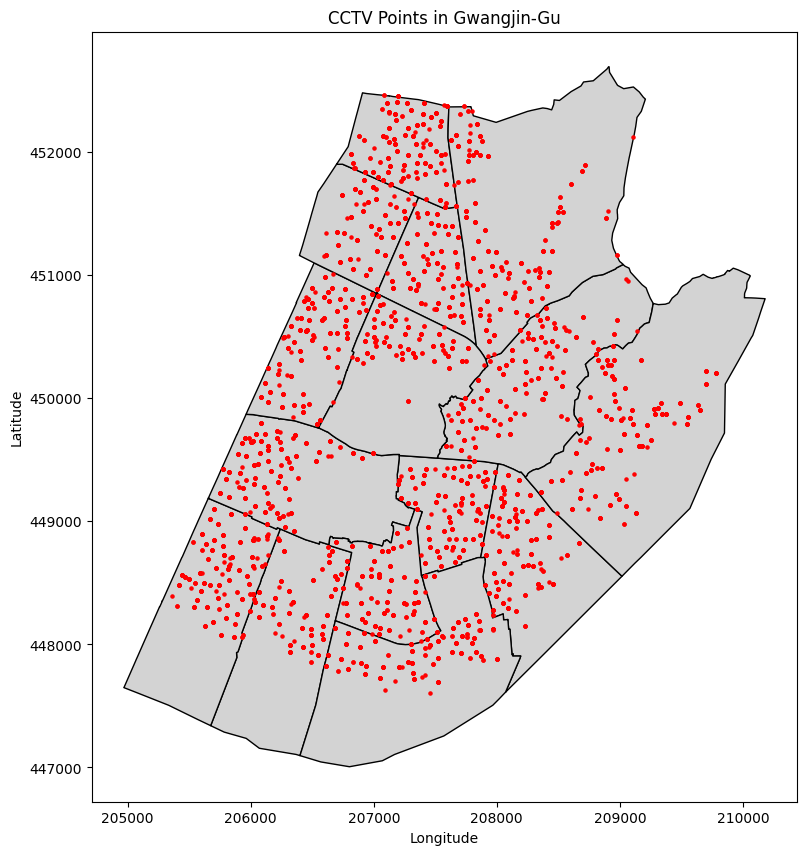

In [53]:
# Plot the gwanjin map
gwangjin_ad.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

# Plot the cctv_gdf points
cctv_df.plot(ax=plt.gca(), color='red', markersize=5)

# Set the title and labels
plt.title('CCTV Points in Gwangjin-Gu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## 경찰청_경철차관서 위치 주소 현황.csv

In [54]:
csv_dict["경찰청_경찰관서 위치 주소 현황_20230811.csv"].head()

,연번,시도청,경찰서,관서명,구분,전화번호,주소
0,1,서울청,서울중부,을지,지구대,02-2279-1908,서울특별시 중구 을지로 234
1,2,서울청,서울중부,광희,지구대,02-2233-1444,서울특별시 중구 퇴계로 375-1
2,3,서울청,서울중부,약수,지구대,02-2234-8112,"서울특별시 중구 동호로 5길 15, 약수지구대"
3,4,서울청,서울중부,신당,파출소,02-2252-0435,"서울특별시 중구 다산로 248 (신당동, 신당파출소)"
4,5,서울청,서울중부,장충,파출소,02-2274-9003,서울특별시 중구 동호로 261


In [55]:
csv_dict["경찰청_경찰관서 위치 주소 현황_20230811.csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연번      2051 non-null   int64 
 1   시도청     2051 non-null   object
 2   경찰서     2051 non-null   object
 3   관서명     2051 non-null   object
 4   구분      2051 non-null   object
 5   전화번호    2049 non-null   object
 6   주소      2049 non-null   object
dtypes: int64(1), object(6)
memory usage: 112.3+ KB


In [56]:
police_df = csv_dict["경찰청_경찰관서 위치 주소 현황_20230811.csv"].copy()
police_df = police_df[police_df["경찰서"]=="서울광진"]
police_df.reset_index(drop=True, inplace=True)
police_df

,연번,시도청,경찰서,관서명,구분,전화번호,주소
0,102,서울청,서울광진,광나루,지구대,02-2285-7820,서울특별시 광진구 아차산로 567
1,103,서울청,서울광진,화양,지구대,02-2285-7810,서울특별시 광진구 능동로17길 39
2,104,서울청,서울광진,중곡1,파출소,02-2285-7830,서울특별시 광진구 능동로 385
3,105,서울청,서울광진,중곡2,파출소,02-2285-7840,서울특별시 광진구 능동로 346
4,106,서울청,서울광진,중곡3,파출소,02-2285-7850,서울특별시 광진구 동일로76가길 28
5,107,서울청,서울광진,중곡4,파출소,02-2285-7860,서울특별시 광진구 용마산로24길 7
6,108,서울청,서울광진,자양,파출소,02-2285-7870,서울특별시 광진구 뚝섬로36길 9
7,109,서울청,서울광진,자양1,파출소,02-2285-7880,서울특별시 광진구 자양번영로 80
8,110,서울청,서울광진,자양4,파출소,02-2285-7890,서울특별시 광진구 뚝섬로22가길 43
9,111,서울청,서울광진,구의,파출소,02-2285-7800,서울특별시 광진구 광나루로 43길 26


In [57]:
###개인 Client ID와 Secret 필요###
client_id = 'blgwmwwnz6'
client_secret = 'KjUEKstZx7QxdqleuAIsVLJ1fIuL0z0hPvICWeMU'

In [58]:
###네이버지도 API를 이용한 도로명주소 -> 위경도 좌표 변환 geocoding
lat = []
lng = []
count = 0
address = list(police_df["주소"].values)

for add in address:
    enc = parse.quote(add)
    url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query=%s'%(enc)
    request = Request(url)
    request.add_header("X-NCP-APIGW-API-KEY-ID", client_id)
    request.add_header("X-NCP-APIGW-API-KEY", client_secret)

    try:
        response = urlopen(request)

    except Exception as e:
        print(f"Error at {count}: {e}")
        lat, lng = None, None

    else:
        rescode = response.getcode()

        if rescode == 200:
            response_body = response.read().decode('utf-8')
            data = json.loads(response_body)

            if data['addresses'] == []:
                lat, lng = None, None
                print(f"Error at {count}: No results")
            else:
                lng.append(data['addresses'][0]['x'])
                lat.append(data['addresses'][0]['y'])

        else:
            print(f"Error at {count}: HTTP {rescode}")
            lat, lng = None, None

    count += 1
    time.sleep(0.1)

police_df["위도"] = lat
police_df["경도"] = lng

In [59]:
police_df.head()

,연번,시도청,경찰서,관서명,구분,전화번호,주소,위도,경도
0,102,서울청,서울광진,광나루,지구대,02-2285-7820,서울특별시 광진구 아차산로 567,37.5444650,127.1033270
1,103,서울청,서울광진,화양,지구대,02-2285-7810,서울특별시 광진구 능동로17길 39,37.5465421,127.0713152
2,104,서울청,서울광진,중곡1,파출소,02-2285-7830,서울특별시 광진구 능동로 385,37.5637365,127.0827717
3,105,서울청,서울광진,중곡2,파출소,02-2285-7840,서울특별시 광진구 능동로 346,37.5603080,127.0814870
4,106,서울청,서울광진,중곡3,파출소,02-2285-7850,서울특별시 광진구 동일로76가길 28,37.5688084,127.0801736


In [60]:
police_df["geometry"] = gpd.points_from_xy(police_df["경도"], police_df["위도"])
police_df = gpd.GeoDataFrame(police_df, geometry="geometry", crs="EPSG:4326")
police_df = police_df.to_crs("EPSG:5181")

In [61]:
police_df.crs

<Projected CRS: EPSG:5181>
Name: KGD2002 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [62]:
police_df.head()

,연번,시도청,경찰서,관서명,구분,전화번호,주소,위도,경도,geometry
0,102,서울청,서울광진,광나루,지구대,02-2285-7820,서울특별시 광진구 아차산로 567,37.5444650,127.1033270,POINT (209131.317 449444.198)
1,103,서울청,서울광진,화양,지구대,02-2285-7810,서울특별시 광진구 능동로17길 39,37.5465421,127.0713152,POINT (206302.163 449672.104)
2,104,서울청,서울광진,중곡1,파출소,02-2285-7830,서울특별시 광진구 능동로 385,37.5637365,127.0827717,POINT (207312.899 451581.307)
3,105,서울청,서울광진,중곡2,파출소,02-2285-7840,서울특별시 광진구 능동로 346,37.5603080,127.0814870,POINT (207199.726 451200.685)
4,106,서울청,서울광진,중곡3,파출소,02-2285-7850,서울특별시 광진구 동일로76가길 28,37.5688084,127.0801736,POINT (207082.876 452144.030)


In [63]:
police_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   연번        10 non-null     int64   
 1   시도청       10 non-null     object  
 2   경찰서       10 non-null     object  
 3   관서명       10 non-null     object  
 4   구분        10 non-null     object  
 5   전화번호      10 non-null     object  
 6   주소        10 non-null     object  
 7   위도        10 non-null     object  
 8   경도        10 non-null     object  
 9   geometry  10 non-null     geometry
dtypes: geometry(1), int64(1), object(8)
memory usage: 928.0+ bytes


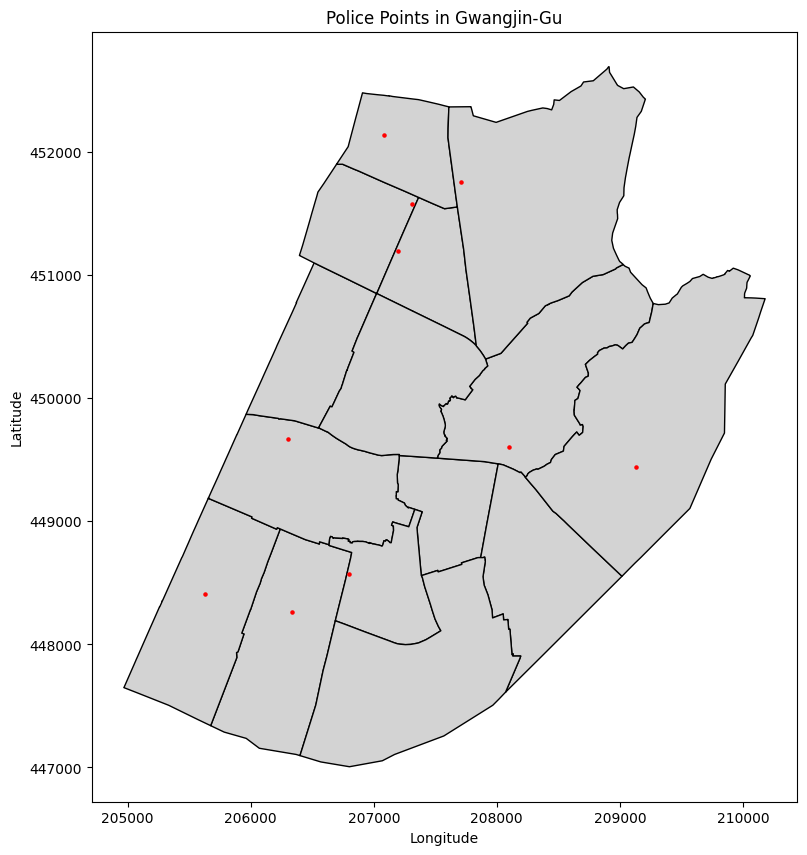

In [64]:
# Plot the gwanjin map
gwangjin_ad.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

# Plot the police_gdf points
# police_df.plot(ax=plt.gca(), color='red', markersize=5)
police_df.plot(ax=plt.gca(), color='red', markersize=5)

# Set the title and labels
plt.title('Police Points in Gwangjin-Gu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## 서울시 버스정류소 위치정보.csv

In [65]:
csv_dict["서울시 버스정류소 위치정보.csv"].head()

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996522,37.579433,중앙차로
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로


In [66]:
csv_dict["서울시 버스정류소 위치정보.csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11290 entries, 0 to 11289
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   노드 ID   11290 non-null  int64  
 1   정류소번호   11290 non-null  int64  
 2   정류소명    11290 non-null  object 
 3   X좌표     11290 non-null  float64
 4   Y좌표     11290 non-null  float64
 5   정류소 타입  11290 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 529.3+ KB


In [67]:
bus_df= csv_dict["서울시 버스정류소 위치정보.csv"].copy()
bus_df["geometry"] = gpd.points_from_xy(bus_df["X좌표"], bus_df["Y좌표"])
bus_df = gpd.GeoDataFrame(bus_df, geometry="geometry", crs="EPSG:4326")
bus_df = bus_df.to_crs("EPSG:5181")
bus_df

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입,geometry
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로,POINT (198917.974 452252.023)
1,100000002,1002,창경궁.서울대학교병원,126.996522,37.579433,중앙차로,POINT (199692.782 453320.222)
2,100000003,1003,명륜3가.성대입구,126.998251,37.582581,중앙차로,POINT (199845.514 453669.610)
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로,POINT (198905.685 452115.650)
4,100000005,1005,혜화동로터리.여운형활동터,127.001744,37.586243,중앙차로,POINT (200154.036 454076.050)
...,...,...,...,...,...,...,...
11285,124000334,25995,우성아파트,127.139339,37.550386,일반차로,POINT (212312.792 450105.435)
11286,124000333,25996,우성아파트,127.140046,37.550643,일반차로,POINT (212375.298 450134.038)
11287,124000332,25997,조일약국,127.123596,37.533630,일반차로,POINT (210924.146 448243.836)
11288,124000331,25998,성내시장,127.125497,37.536155,일반차로,POINT (211091.764 448524.266)


In [68]:
bus_stop_df = gpd.sjoin(bus_df, seoul_ad)
bus_stop_df.head()

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입,geometry,index_right,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로,POINT (198917.974 452252.023),8,11110615,종로1·2·3·4가동,199104.0,452849.0,2417171.0
3,100000004,1004,종로2가.삼일교,126.987613,37.568579,중앙차로,POINT (198905.685 452115.650),8,11110615,종로1·2·3·4가동,199104.0,452849.0,2417171.0
9,100000385,1010,광화문,126.977889,37.570268,중앙차로,POINT (198046.702 452303.230),8,11110615,종로1·2·3·4가동,199104.0,452849.0,2417171.0
10,100000386,1011,종로1가,126.981066,37.570148,중앙차로,POINT (198327.328 452289.884),8,11110615,종로1·2·3·4가동,199104.0,452849.0,2417171.0
11,100000387,1012,종로1가,126.981630,37.570271,중앙차로,POINT (198377.148 452303.499),8,11110615,종로1·2·3·4가동,199104.0,452849.0,2417171.0


In [69]:
bus_stop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 11276 entries, 0 to 11285
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   노드 ID        11276 non-null  int64   
 1   정류소번호        11276 non-null  int64   
 2   정류소명         11276 non-null  object  
 3   X좌표          11276 non-null  float64 
 4   Y좌표          11276 non-null  float64 
 5   정류소 타입       11276 non-null  object  
 6   geometry     11276 non-null  geometry
 7   index_right  11276 non-null  int64   
 8   ADSTRD_CD    11276 non-null  int64   
 9   ADSTRD_NM    11276 non-null  object  
 10  XCNTS_VALU   11276 non-null  float64 
 11  YDNTS_VALU   11276 non-null  float64 
 12  RELM_AR      11276 non-null  float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 1.2+ MB


In [70]:
bus_stop_df = bus_stop_df[bus_stop_df["ADSTRD_CD"].isin(gwangjin_com["ADSTRD_CD"])]
bus_stop_df.head()

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입,geometry,index_right,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR
1420,104000001,5001,군자교입구,127.075646,37.558741,중앙차로,POINT (206683.801 451026.334),113,11215740,중곡1동,206864.0,451399.0,614505.0
1432,104000008,5101,군자교,127.075203,37.561533,일반차로,POINT (206644.397 451336.167),113,11215740,중곡1동,206864.0,451399.0,614505.0
1433,104000009,5102,군자교,127.075229,37.562386,일반차로,POINT (206646.597 451430.877),113,11215740,중곡1동,206864.0,451399.0,614505.0
1434,104000010,5103,메리놀외방선교회,127.077338,37.558950,일반차로,POINT (206833.268 451049.653),113,11215740,중곡1동,206864.0,451399.0,614505.0
1435,104000011,5104,메리놀외방선교회,127.077632,37.559087,일반차로,POINT (206859.220 451064.838),113,11215740,중곡1동,206864.0,451399.0,614505.0


In [71]:
bus_stop_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 293 entries, 1420 to 1707
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   노드 ID        293 non-null    int64   
 1   정류소번호        293 non-null    int64   
 2   정류소명         293 non-null    object  
 3   X좌표          293 non-null    float64 
 4   Y좌표          293 non-null    float64 
 5   정류소 타입       293 non-null    object  
 6   geometry     293 non-null    geometry
 7   index_right  293 non-null    int64   
 8   ADSTRD_CD    293 non-null    int64   
 9   ADSTRD_NM    293 non-null    object  
 10  XCNTS_VALU   293 non-null    float64 
 11  YDNTS_VALU   293 non-null    float64 
 12  RELM_AR      293 non-null    float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 32.0+ KB


In [72]:
csv_dict["서울시 버스정류소 위치정보.csv"] = bus_stop_df

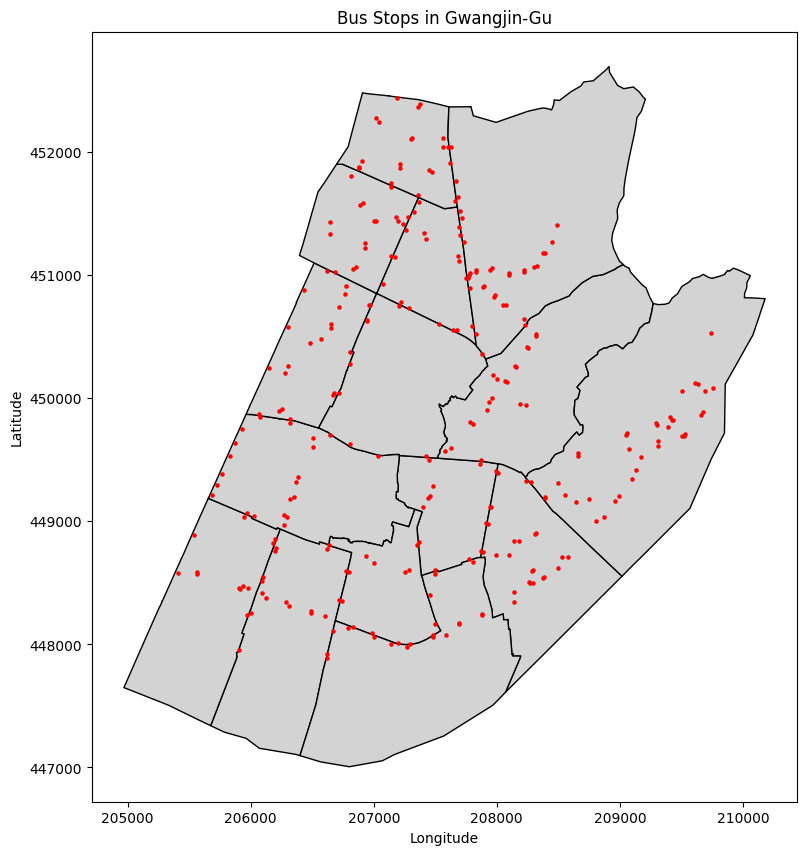

In [73]:
# Plot the gwanjin map
gwangjin_ad.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

# Plot the bus_stop_gdf points
bus_stop_df.plot(ax=plt.gca(), color='red', markersize=5)

# Set the title and labels
plt.title('Bus Stops in Gwangjin-Gu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## 서울교통공사 지하철역 주소 및 전화번호 정보.csv

In [74]:
csv_dict["서울교통공사 지하철역 주소 및 전화번호 정보.csv"].head()

,호선,역명,구주소,도로명주소,전화번호
0,2호선,봉천,서울특별시 관악구 봉천동 979-7 봉천역(2호선),서울특별시 관악구 남부순환로 지하1721(봉천동),02-6110-2291
1,1호선,서울,서울특별시 중구 남대문로5가 73-6 서울역(1호선),서울특별시 중구 세종대로 지하2(남대문로 5가),02-6110-1331
2,1호선,시청,서울특별시 중구 정동 5-5 시청역(1호선),서울특별시 중구 세종대로 지하101(정동),02-6110-1321
3,1호선,종각,서울특별시 종로구 종로1가 54 종각역(1호선),서울특별시 종로구 종로 지하55(종로1가),02-6110-1311
4,1호선,종로3가,서울특별시 종로구 종로3가 10-5 종로3가역(1호선),서울특별시 종로구 종로 지하129(종로3가),02-6110-1301


In [75]:
csv_dict["서울교통공사 지하철역 주소 및 전화번호 정보.csv"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   호선      288 non-null    object
 1   역명      288 non-null    object
 2   구주소     288 non-null    object
 3   도로명주소   288 non-null    object
 4   전화번호    288 non-null    object
dtypes: object(5)
memory usage: 11.4+ KB


In [76]:
subway_df = csv_dict["서울교통공사 지하철역 주소 및 전화번호 정보.csv"].copy()
station = ["중곡", "군자", "어린이대공원", "건대입구", "뚝섬유원지", "구의", "강변", "광나루", "아차산"]
subway_df = subway_df[subway_df["역명"].str.contains("|".join(station))]
subway_df["filtered_address"] = subway_df["도로명주소"].apply(lambda x: re.sub(r'지하', '', x))
subway_df["filtered_address"] = subway_df["filtered_address"].apply(lambda x: re.sub(r'\(.*\)', '', x))
subway_df.reset_index(drop=True, inplace=True)
subway_df

,호선,역명,구주소,도로명주소,전화번호,filtered_address
0,2호선,건대입구,서울특별시 광진구 화양동 7-3 2호선 건대입구역(2호선),서울특별시 광진구 아차산로 243(화양동),02-6110-2121,서울특별시 광진구 아차산로 243
1,2호선,구의(광진구청),서울특별시 광진구 구의동 245-24 구의역(2호선),서울특별시 광진구 아차산로 384-1(구의동),02-6110-2131,서울특별시 광진구 아차산로 384-1
2,2호선,강변(동서울터미널),서울특별시 광진구 구의동 546-6 강변역(2호선),서울특별시 광진구 강변역로 53(구의동),02-6110-2141,서울특별시 광진구 강변역로 53
3,5호선,군자(능동),서울특별시 광진구 능동 275-5 군자(능동)역(5호선),서울특별시 광진구 천호대로 지하550(능동),02-6311-5441,서울특별시 광진구 천호대로 550
4,5호선,아차산(어린이대공원후문),서울특별시 광진구 능동 256-16 5호선 아차산역(5호선),서울특별시 광진구 천호대로 지하657(능동),02-6311-5451,서울특별시 광진구 천호대로 657
5,5호선,광나루(장신대),서울특별시 광진구 광장동 237 광나루역(5호선),서울특별시 광진구 아차산로 지하571(광장동),02-6311-5461,서울특별시 광진구 아차산로 571
6,7호선,중곡,서울특별시 광진구 중곡동 273-2 7호선 중곡역(7호선),서울특별시 광진구 능동로 지하417(중곡동),02-6311-7241,서울특별시 광진구 능동로 417
7,7호선,군자(능동),서울특별시 광진구 능동 275-5 군자(능동)역(7호선),서울특별시 광진구 천호대로 지하550(능동),02-6311-5441,서울특별시 광진구 천호대로 550
8,7호선,어린이대공원(세종대),서울특별시 광진구 화양동 164-1 어린이대공원역(7호선),서울특별시 광진구 능동로 지하210(화양동),02-6311-7261,서울특별시 광진구 능동로 210
9,7호선,건대입구,서울특별시 광진구 화양동 6-3 건대입구역(7호선),서울특별시 광진구 능동로 지하110(화양동),02-6311-7271,서울특별시 광진구 능동로 110


In [77]:
###네이버지도 API를 이용한 도로명주소 -> 위경도 좌표 변환 geocoding
lat = []
lng = []
count = 0
address = list(subway_df["filtered_address"].values)

for add in address:
    enc = parse.quote(add)
    url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query=%s'%(enc)
    request = Request(url)
    request.add_header("X-NCP-APIGW-API-KEY-ID", client_id)
    request.add_header("X-NCP-APIGW-API-KEY", client_secret)

    try:
        response = urlopen(request)

    except Exception as e:
        print(f"Error at {count}: {e}")
        lat, lng = None, None

    else:
        rescode = response.getcode()

        if rescode == 200:
            response_body = response.read().decode('utf-8')
            data = json.loads(response_body)

            if data['addresses'] == []:
                lat, lng = None, None
                print(f"Error at {count}: No results")
            else:
                lng.append(data['addresses'][0]['x'])
                lat.append(data['addresses'][0]['y'])

        else:
            print(f"Error at {count}: HTTP {rescode}")
            lat, lng = None, None

    count += 1
    time.sleep(0.1)

subway_df["위도"] = lat
subway_df["경도"] = lng

In [78]:
subway_df.head()

,호선,역명,구주소,도로명주소,전화번호,filtered_address,위도,경도
0,2호선,건대입구,서울특별시 광진구 화양동 7-3 2호선 건대입구역(2호선),서울특별시 광진구 아차산로 243(화양동),02-6110-2121,서울특별시 광진구 아차산로 243,37.5404189,127.0691733
1,2호선,구의(광진구청),서울특별시 광진구 구의동 245-24 구의역(2호선),서울특별시 광진구 아차산로 384-1(구의동),02-6110-2131,서울특별시 광진구 아차산로 384-1,37.5371529,127.0861579
2,2호선,강변(동서울터미널),서울특별시 광진구 구의동 546-6 강변역(2호선),서울특별시 광진구 강변역로 53(구의동),02-6110-2141,서울특별시 광진구 강변역로 53,37.5351693,127.0946646
3,5호선,군자(능동),서울특별시 광진구 능동 275-5 군자(능동)역(5호선),서울특별시 광진구 천호대로 지하550(능동),02-6311-5441,서울특별시 광진구 천호대로 550,37.5573632,127.0790173
4,5호선,아차산(어린이대공원후문),서울특별시 광진구 능동 256-16 5호선 아차산역(5호선),서울특별시 광진구 천호대로 지하657(능동),02-6311-5451,서울특별시 광진구 천호대로 657,37.5524011,127.0893706


In [79]:
subway_df["geometry"] = gpd.points_from_xy(subway_df["경도"], subway_df["위도"])
subway_df = gpd.GeoDataFrame(subway_df, geometry="geometry", crs="EPSG:4326")
subway_df = subway_df.to_crs("EPSG:5181")

In [80]:
subway_df.crs

<Projected CRS: EPSG:5181>
Name: KGD2002 / Central Belt
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - between 126°E and 128°E - mainland and nearshore.
- bounds: (126.0, 33.96, 128.0, 38.33)
Coordinate Operation:
- name: Korea Central Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [81]:
subway_df

,호선,역명,구주소,도로명주소,전화번호,filtered_address,위도,경도,geometry
0,2호선,건대입구,서울특별시 광진구 화양동 7-3 2호선 건대입구역(2호선),서울특별시 광진구 아차산로 243(화양동),02-6110-2121,서울특별시 광진구 아차산로 243,37.5404189,127.0691733,POINT (206113.382 448992.361)
1,2호선,구의(광진구청),서울특별시 광진구 구의동 245-24 구의역(2호선),서울특별시 광진구 아차산로 384-1(구의동),02-6110-2131,서울특별시 광진구 아차산로 384-1,37.5371529,127.0861579,POINT (207614.775 448631.115)
2,2호선,강변(동서울터미널),서울특별시 광진구 구의동 546-6 강변역(2호선),서울특별시 광진구 강변역로 53(구의동),02-6110-2141,서울특별시 광진구 강변역로 53,37.5351693,127.0946646,POINT (208366.833 448411.683)
3,5호선,군자(능동),서울특별시 광진구 능동 275-5 군자(능동)역(5호선),서울특별시 광진구 천호대로 지하550(능동),02-6311-5441,서울특별시 광진구 천호대로 550,37.5573632,127.0790173,POINT (206981.792 450873.661)
4,5호선,아차산(어린이대공원후문),서울특별시 광진구 능동 256-16 5호선 아차산역(5호선),서울특별시 광진구 천호대로 지하657(능동),02-6311-5451,서울특별시 광진구 천호대로 657,37.5524011,127.0893706,POINT (207897.110 450323.746)
5,5호선,광나루(장신대),서울특별시 광진구 광장동 237 광나루역(5호선),서울특별시 광진구 아차산로 지하571(광장동),02-6311-5461,서울특별시 광진구 아차산로 571,37.5452787,127.1036865,POINT (209162.987 449534.544)
6,7호선,중곡,서울특별시 광진구 중곡동 273-2 7호선 중곡역(7호선),서울특별시 광진구 능동로 지하417(중곡동),02-6311-7241,서울특별시 광진구 능동로 417,37.5655259,127.0840725,POINT (207427.648 451780.012)
7,7호선,군자(능동),서울특별시 광진구 능동 275-5 군자(능동)역(7호선),서울특별시 광진구 천호대로 지하550(능동),02-6311-5441,서울특별시 광진구 천호대로 550,37.5573632,127.0790173,POINT (206981.792 450873.661)
8,7호선,어린이대공원(세종대),서울특별시 광진구 화양동 164-1 어린이대공원역(7호선),서울특별시 광진구 능동로 지하210(화양동),02-6311-7261,서울특별시 광진구 능동로 210,37.5478712,127.0745499,POINT (206587.898 449819.840)
9,7호선,건대입구,서울특별시 광진구 화양동 6-3 건대입구역(7호선),서울특별시 광진구 능동로 지하110(화양동),02-6311-7271,서울특별시 광진구 능동로 110,37.5406610,127.0714121,POINT (206311.221 449019.379)


In [82]:
subway_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   호선                11 non-null     object  
 1   역명                11 non-null     object  
 2   구주소               11 non-null     object  
 3   도로명주소             11 non-null     object  
 4   전화번호              11 non-null     object  
 5   filtered_address  11 non-null     object  
 6   위도                11 non-null     object  
 7   경도                11 non-null     object  
 8   geometry          11 non-null     geometry
dtypes: geometry(1), object(8)
memory usage: 920.0+ bytes


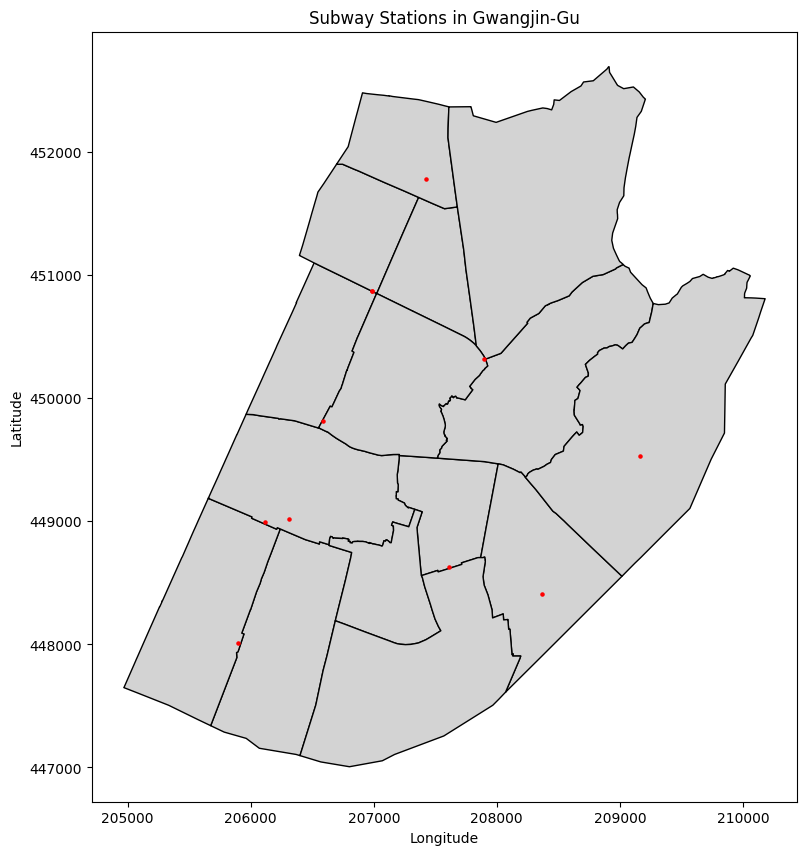

In [83]:
# Plot the gwanjin map
gwangjin_ad.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

# Plot the subway_gdf points
subway_df.plot(ax=plt.gca(), color='red', markersize=5)

# Set the title and labels
plt.title('Subway Stations in Gwangjin-Gu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# pre-processed Data pickle

In [84]:
data_dict = {}

In [85]:
data_dict["gwangjin_com"] = gwangjin_com
data_dict["gwangjin_admin"] = gwangjin_ad
data_dict["work_pop"] = work_df
data_dict["live_pop"] = live_df
data_dict["est_sales"] = sales_df
data_dict["att_fac"] = facil_df
data_dict["income_cons"] = money_df
data_dict["cctv"] = cctv_df
data_dict["police"] = police_df
data_dict["bus"] = bus_df
data_dict["subway"] = subway_df

In [87]:
with open(f'./processed_data.pkl', 'wb') as f: # Save pre-processed data
    pickle.dump(data_dict, f)